In [1]:
import numpy as np
import matplotlib.pyplot as plt
from math import e, exp, log, sqrt
from scipy.stats import norm
plt.style.use('ggplot')

np.random.seed(42)
%matplotlib inline

In this notebook, we'll explore using Gaussian noise to provide differential privacy guarantees. It has some nice properties, including the fact that we are used to reasoning about normally distributed error/noise!

Let's use our same dataset to get an idea and compare between these different implementations of differential privacy. 

In [2]:
mid_level_age = 45
mid_level_salary = 50000

age_scale = 10 #scale represents one standard deviation
salary_scale = 10000

salaries = [round(np.random.normal(mid_level_salary,salary_scale)) for _ in range(100)]
ages = [round(np.random.normal(mid_level_age,age_scale)) for _ in range(100)]

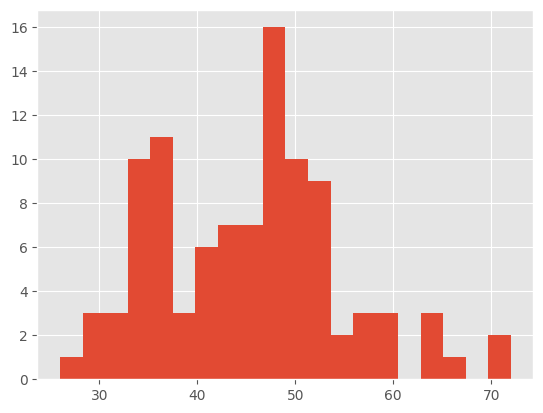

In [3]:
plt.hist(ages, bins=20);

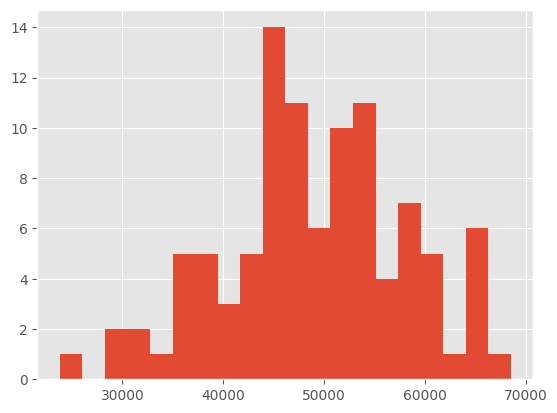

In [4]:
plt.hist(salaries, bins=20);

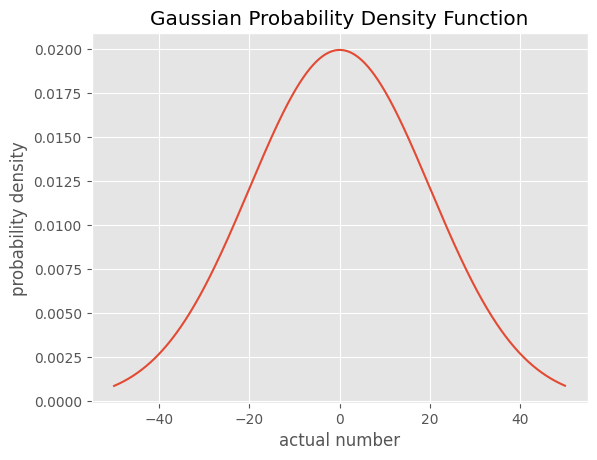

In [5]:
loc = 0
scale = 20

x = np.arange(-50., 50., 0.1)
pdf = norm.pdf(x, loc, scale)

fig,ax= plt.subplots()
ax.plot(x, pdf)
ax.set_title('Gaussian Probability Density Function')
ax.set_xlabel('actual number')
ax.set_ylabel('probability density');

In order to scale our Gaussian distribution to meet differential privacy guarantees, we need to define our sensitivity, delta and epsilon. Let's keep it close to our prior notebook (with the exception that Laplace never needs Delta!). 

NOTE: This formula is only good for epsilon < 1 and is not as optimized (i.e. it adds more noise than necessary to meet the guarantees!). For real problems, please use a well-reviewed differential privacy library.

In [6]:
sensitivity=1
delta = 10**-5
epsilon=0.99
sigma_squared = (2*sensitivity**2*log(1.25/delta))/epsilon**2 
sigma_squared

23.94871751103854

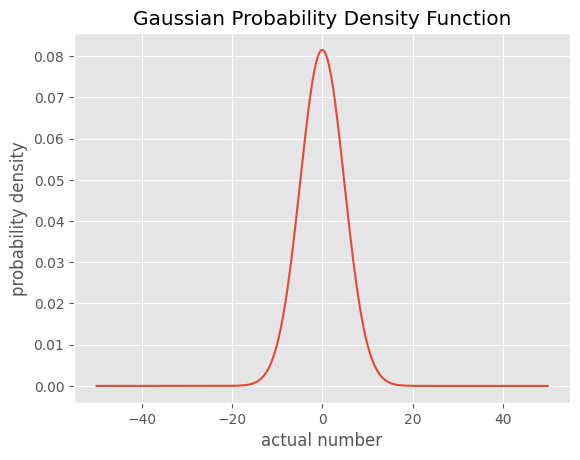

In [7]:
loc = 0
scale = sqrt(sigma_squared)

x = np.arange(-50., 50., 0.1)
pdf = norm.pdf(x, loc, scale)

fig,ax= plt.subplots()
ax.plot(x, pdf)
ax.set_title('Gaussian Probability Density Function')
ax.set_xlabel('actual number')
ax.set_ylabel('probability density');

This is a great time to remind ourselves that sensitivity for the Gaussian mechanism is different! (More on this in a minute!)


### Gaussian DP Mechanism

Let's now implement a toy-example, please do not use this in real life! Instead, use a properly audited and well-known open-source library. :)

In [8]:
epsilon = 0.99 # Must be less than 1 to use this implementation!
sensitivity = 1 
delta=10**-5


def gaussian_dp_mechanism(value, epsilon, sensitivity=sensitivity):
    # Please do not use this function in real life - it is susceptible to well known attacks
    # instead, use a well-known and audited open-source DP library 
    orig_value = value
    gauss_scale = sqrt((2*sensitivity**2*log(1.25/delta))/epsilon**2)
    value =  np.random.normal(value, gauss_scale)
    print("Noise: {}".format(value - orig_value))
    return value

In [9]:
gaussian_dp_mechanism(len(ages), epsilon)

Noise: 1.75091927910006


101.75091927910006

In [10]:
def filter_bounds(value, lower_bound, upper_bound):
    if value < lower_bound:
        return lower_bound
    elif value > upper_bound:
        return upper_bound
    return value

What about if we want to answer a more complicated query, like a sum? We need to know exactly how much one person can affect our outcome. Since we know this is a dataset of working persons, we might choose upper and lower bounds to artificially limit the amount that one person can affect the dataset. 

Let's take a look at how that might work with our ages!

In [11]:
bounded_ages = [filter_bounds(age, 20, 70) for age in ages]

In [12]:
gaussian_dp_mechanism(np.sum(bounded_ages), epsilon, sensitivity=50)

Noise: 137.21675881497413


4663.216758814974

In [13]:
sum(ages)

4528

And we can see how we want to spend our budget and adjust. Our count has lower sensitivity, so we will spend less on it. Of course, you may need to adjust your queries not only based on sensitivity, but also how accurate you want your query result to be!

In [14]:
count_epsilon = 0.20
sum_epsilon = 0.79
summed_ages = gaussian_dp_mechanism(np.sum(bounded_ages), sum_epsilon, sensitivity=50)
count_ages = gaussian_dp_mechanism(len(bounded_ages), count_epsilon, sensitivity=1)

mean_age = summed_ages / count_ages
mean_age

Noise: 332.0995166206894
Noise: 25.527328637215277


38.7015287377063

In [16]:
(np.mean(ages) - mean_age) / np.mean(ages)

0.14528425932627437

So far, we've measured sensitivity by figuring out how much one person can affect a result. But there is actually a second dimension to sensitivity: how many different statistics can a user influence? This is called `l0`, while the concept we've been working on up to this point is called `l_inf`. 

For example, if users are logging in and reading their email and we want to calculate average reading time per email -- a prolific user could end up adding 100s or 1000s or read times per day. Another user might just read one email or less per day. These users have much different privacy loss in the overall average, even if we do bound the reading time of any single email using `linf_sensitivity`.


### Comparing Laplace and Gaussian Noise

Let's take a look at how Laplace and Gaussian noise compare with one another. To do so, we'll want to analyze how many distinct statistics a user can affect (this is also the `l0_sensitivity`). In this example, we'll use a better approximation for the Gaussian noise.

NOTE: These functions were built based on [the Google Differential Privacy Library implementation of Gaussian noise.](https://github.com/google/differential-privacy/blob/0e95b99af5fedff95b8cab3739009bbc1366c068/go/noise/gaussian_noise.go)

In [ ]:
def delta_for_gaussian(sigma, l0_sensitivity, linf_sensitivity, epsilon):
    l2_sensitivity = linf_sensitivity * sqrt(l0_sensitivity)
    a = l2_sensitivity / (2*sigma)
    b = epsilon * sigma / l2_sensitivity
    c = exp(epsilon)
    
    if np.isinf(c): 
        return 0
    if np.isinf(b):
        return 0
    return norm.cdf (a-b) - norm.cdf(-a-b)

In [ ]:
gaussianSigmaAccuracy = 1e-3

def sigma_for_gaussian(l0_sensitivity, linf_sensitivity, epsilon, delta):
    if delta >=1:
        return 0
    
    l2_sensitivity = linf_sensitivity * sqrt(l0_sensitivity)
    upper_bound = l2_sensitivity
    
    while delta_for_gaussian(upper_bound, l0_sensitivity, linf_sensitivity, epsilon) > delta:
        lower_bound = upper_bound
        upper_bound = upper_bound * 2
    
    while upper_bound - lower_bound > gaussianSigmaAccuracy * lower_bound:
        middle = lower_bound * 0.5 + upper_bound * 0.5
        if delta_for_gaussian(middle, l0_sensitivity, linf_sensitivity, epsilon) > delta:
            lower_bound = middle
        else:
            upper_bound = middle
            
    return upper_bound

In [ ]:
epsilon = 1
delta = 10**-5

In [ ]:
l0_sensitivity = 1 # Number of statistics one user influences
linf_sensitivity = 5

laplace_std_dev = sqrt(2)*l0_sensitivity*linf_sensitivity
gauss_std_dev = sigma_for_gaussian(l0_sensitivity, linf_sensitivity, 
                                   epsilon, delta)

In [ ]:
gauss_std_dev

In [ ]:
laplace_std_dev

In [ ]:
x = np.arange(1., 20, 1)
fig,ax= plt.subplots()

laplace_stddev = sqrt(2)*x
ax.plot(x, laplace_stddev , label='Laplace')


gauss_std_dev = [sqrt(sigma_for_gaussian(l0, sensitivity, epsilon, delta)) for l0 in x]
ax.plot(x, gauss_std_dev, label='Gaussian')
    
ax.set_xlabel('l0 sensitivity')
ax.set_ylabel('standard deviations')
ax.legend()

### Challenge

- Use the dataset from the Opacus notebook with the methods in this notebook to calculate anonymous statistics about the reviews. 
- Find another open review dataset on Kaggle. Compare using the methods from this notebook to the ones from the Laplace notebook. Can you compare the normalized error?